In [ ]:
import pandas as pd
from scipy.stats import kendalltau, pearsonr, spearmanr
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Analysis of All Catchments So Far

- currently provided with 466 catchment-worth of data, 24% less than 618 reported in Nienke's sample
- cross correlation 
['ndvi', 'evi', 'nbr', 'ndmi', 'gndvi', 'ndbi', 'BRIGHTNESS','GREENNESS', 'WETNESS']
                                                    VS
['AI', 'EI', 'SI', 'ST', 'T', 'is_dur', 'omega']

and their respective pairs to find the highest corresponding pairs

In [423]:
abs_path = 'C:/users/creeb/ThesisGit/Thesis_Git_MOH'

meuse = pd.read_excel(f'{abs_path}/meuse/meuse_all_decadal_indices_combined_1.xlsx')#, index_col='system_index')
meuse_delta = pd.read_excel(f'{abs_path}/meuse/meuse_all_decadal_delta_1.xlsx')#, index_col='system_index')

#ThesisGit/Thesis_Git_MOH/meuse/meuse_all_decadal_indices_combined_1.xlsx

GB = pd.read_excel(f'{abs_path}/camels_GB/camels_GB_all_decadal_indices_combined_1.xlsx')#, index_col='system_index')
GB_delta = pd.read_excel(f'{abs_path}/camels_GB/camels_GB_all_decadal_delta_1.xlsx')#, index_col='system_index')


USA = pd.read_excel(f'{abs_path}/camels_USA/camels_USA_all_decadal_indices_combined_1.xlsx')#, index_col='system_index')
USA_delta = pd.read_excel(f'{abs_path}/camels_USA/camels_USA_all_decadal_delta_1.xlsx')#, index_col='system_index')

SR_indices = meuse.keys()[14:23]
SR_delta_indices = meuse_delta.keys()[14:23]
SR_exclude = meuse.keys()[0:23]
SR_delta_exclude =  meuse_delta.keys()[0:23]

fignum = 0

In [ ]:
meuse_grouped = meuse.groupby('system_index')

label = ['AI', 'EI', 'ndvi', 'ndbi', 'gndvi', 'ndmi']


plt.figure(figsize=(10, 6.18))

for i, (group, data) in enumerate(meuse_grouped):
    if group == '00000000000000000027':
        for j in label:
            plt.plot(data.decade_ending, data.loc[:, j], ls='--', label=f'{j} [-]')
            plt.scatter(data.decade_ending, data.loc[:, j], marker='+')
            plt.xticks(data.decade_ending)
            plt.xlabel(f'Decadal Mean Values')
            plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.02))
        #display(data)

In [ ]:
def key_intersection(df1, df2, df3):
    k1 , k2, k3 = set(df1.keys().values), set(df2.keys().values), set(df3.keys().values)
    intersection = k1.intersection(k2).intersection(k3)
    return intersection

def kendall_pval(x,y):
    return kendalltau(x,y)[1]

def pearsonr_pval(x,y):
    return pearsonr(x,y)[1]

def spearmanr_pval(x,y):
    return spearmanr(x,y)[1]


In [ ]:
keys = key_intersection(meuse, GB, USA)#.symmetric_difference(SR_indices)
d_keys = key_intersection(meuse_delta, GB_delta, USA_delta)#.symmetric_difference(SR_delta_indices)

WB_keys = {'LT_AI', 'LT_EI', 'LT_SR', 'AI', 'EI', 'SI', 'ST', 'T', 'is_dur', 'omega'}


In [ ]:
def create_combined_table(df1, df2, df3, keys):
    combo = pd.DataFrame()
    for key in keys:
        a = df1.loc[:, key]
        b = df2.loc[:, key]
        c = df3.loc[:, key]
        
        combo_col = list(itertools.chain(*(a.to_list(),
                                                 b.to_list(),
                                                c.to_list(),))) 
        
        combo[key] = combo_col
    
    prs_r = combo.corr()
    
    p = combo.corr(method=pearsonr_pval)
    
    return [combo, prs_r, p]
        

In [416]:
combo, prs_r, p = create_combined_table(meuse, GB, USA, keys)
d_combo, d_r, d_p = create_combined_table(meuse_delta, GB_delta, USA_delta, d_keys)

In [ ]:
def sorted_p(p):
    p.replace(1, np.nan)
    sorted_p = pd.DataFrame()

    for i in p.keys()[:]:
        sort = pd.DataFrame(p.loc[:, i].sort_values(ascending=False))
        sorted_p[f'{i}_vs'] = sort.index
        sorted_p[f'{i}_p'] = sort.values
    return sorted_p

In [197]:
sort_p = sorted_p(p)
sort_dp = sorted_p(d_p)

In [198]:
def plot_descending_P(SR_index:[], df_all, sorted_p, prs_r, exclude, delta=False, plot=False, savefig=False, color_by=str, levels=[]):
    '''
    The function loops through the list of Surface Reflectance indices passed. The plotting returns scatters in descending
    order from   to:  1 > p-value > 0.01 
    '''
    ls = []
    
    for i in SR_index:
        
        if delta==True:
            i = f'd_{i}'

        high_to_low_id = sorted_p.loc[:, f'{i}_vs']
        high_to_low_p = sorted_p.loc[:, f'{i}_p']
        
        for j in zip(high_to_low_id, high_to_low_p):
            if j[1] < 0.1 and j[0] not in exclude:
                
                
                r = prs_r.loc[i, j[0]]
                ls.append((i, j[0], j[1], r))
                
                
                if plot == True:
                    plt.figure(figsize=(10, 6.18))
                    
                    
                    
                    x = df_all.loc[:, i] 

                    y = df_all.loc[:, j[0]]


                    plt.suptitle(f'$p$: {j[1]:.3e}, $r$= {r:.3e}, $n$ = {len(x)}')
        
                    plt.xlabel(i)

                    plt.ylabel(j[0])
                
                
                if delta==True and plot == True:
                    
                    plt.title(f'$\Delta$ {i[2:]}  vs $\Delta$ {j[0][2:]}')
                    
                    plt.scatter(x, y, c=df_all.loc[:,  color_by], alpha=0.6)
    
                    plt.colorbar(ticks=levels, label=color_by)
                    
                    plt.xlabel(f'$\Delta${i[2:]}')

                    plt.ylabel(f'$\Delta${j[0][2:]}')
        
                    if savefig == True:
                
                        plt.savefig(f'outputs/SR_delta_correlations/{i}_{j[0]}_{color_by}')

                elif delta==False and plot == True:    
                    

                    plt.title(f'{i} vs  {j[0]}')
                    
                    plt.scatter(x, y, c=df_all.loc[:,  color_by], alpha=0.6)
                    
                    plt.colorbar(ticks=levels, label=color_by)
                    
                    if savefig == True:
                        plt.savefig(f'outputs/SR_correlations/{i}_{j[0]}_{color_by}')
                
                ##if j[1] <= 0.1:
                    #break
                
            else:
                None
        
    return ls

In [ ]:
#SR_indices
years_levels = [1989, 1999, 2009, 2015]
AI_levels = [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
AI_levels_used = [0.2, 0.4, 0.6, 0.8, 1, 1.2]
folder_stem = 'outputs/SR_delta_correlations'
 
#ranking = plot_descending_P(SR_indices, combo, sort_p, prs_r, SR_exclude, delta=False, plot=True, savefig=False, color_by='decade_ending', levels = years_levels)
ranking = plot_descending_P(SR_indices, combo, sort_p, prs_r, SR_exclude, delta=False, plot=True, savefig=True, color_by='LT_AI', levels = AI_levels, folder_stem=folder_stem)

#sort_p.keys()

In [200]:
df_ranking = pd.DataFrame(ranking, columns= ['SR_ind', 'WB_Clim_ind', 'prs_P', 'prs_R']).sort_values('prs_P')
df_ranking.to_excel(f'outputs/SR_correlations/ranking_correlatons.xlsx')
df_ranking

,SR_ind,WB_Clim_ind,prs_P,prs_R
36,ndbi,is_dur,1.216660e-43,0.582255
23,ndmi,is_dur,1.216660e-43,-0.582255
55,WETNESS,is_dur,1.451799e-40,-0.564460
35,ndbi,AI,8.293767e-35,0.527972
22,ndmi,AI,8.293767e-35,-0.527972
16,nbr,is_dur,1.269822e-32,-0.512868
54,WETNESS,ST,4.333393e-32,-0.509065
15,nbr,AI,1.263753e-31,-0.505710
53,WETNESS,AI,7.796047e-31,-0.499919
34,ndbi,ST,4.870574e-27,0.470450


In [ ]:
delta_years_levels = [1995, 1999, 2009, 2015]

delta_ranking = plot_descending_P(SR_indices, d_combo, sort_dp, d_r, SR_delta_exclude, delta=True, plot=True, savefig=True, color_by='LT_AI', levels = AI_levels)

In [202]:
df_ranked_delta = pd.DataFrame(delta_ranking, columns= ['SR_ind', 'WB_Clim_ind', 'prs_P', 'prs_R']).sort_values('prs_P')
df_ranked_delta.to_excel(f'outputs/SR_delta_correlations/ranking_delta_correlatons.xlsx')
df_ranked_delta

,SR_ind,WB_Clim_ind,prs_P,prs_R
20,d_gndvi,d_T,3.424052e-08,-0.348962
19,d_gndvi,d_is_dur,1.348645e-07,0.334323
33,d_GREENNESS,d_is_dur,2.050014e-07,0.329696
18,d_gndvi,d_ST,1.302789e-06,0.308288
28,d_BRIGHTNESS,d_T,6.161913e-06,0.288896
32,d_GREENNESS,d_T,8.046405e-06,-0.285419
31,d_GREENNESS,d_ST,3.941898e-05,0.263682
5,d_ndvi,d_is_dur,4.572550e-05,0.261554
4,d_ndvi,d_T,5.035324e-05,-0.260161
3,d_ndvi,d_ST,3.019763e-04,0.232728


# Grouping Delta Table by Aridity

 - first gather the aridity classes per index
 - Adapt the function of plotting the aridity classes as defined by nienke

In [308]:
combo

,B4,ndbi,country_code,system_index,catchment_name,ndvi,SI,LT_SR,B2,Unnamed: 0,...,is_dur,gndvi,EI,ndmi,B5,AI,nbr,omega,GREENNESS,B1
0,3505.870580,-0.261393,FR,00000000000000000027,La Meuse Stenay,0.646986,0.130338,136.127009,795.529580,0,...,4.209709,0.630203,0.523830,0.261393,2075.404309,0.723527,0.535894,2.195433,1947.346107,500.667264
1,3854.445260,-0.279797,FR,0000000000000000001c,La Vence la Francheville,0.706225,0.222241,185.448285,770.271634,1,...,4.320080,0.669060,0.409847,0.279797,2176.186161,0.538129,0.570896,2.050072,2283.432161,473.134882
2,3689.468405,-0.281666,FR,00000000000000000023,La Bar Cheveuges,0.688455,0.190065,267.844657,771.648832,2,...,4.293069,0.656230,0.580658,0.281666,2084.878494,0.600242,0.571166,4.632337,2146.471886,480.667394
3,3548.118212,-0.273264,FR,00000000000000000026,Le Loison Han-lÃ©s-Juvigny,0.682117,0.181241,259.431829,735.486661,3,...,4.365462,0.655333,0.617702,0.273264,2045.911644,0.638256,0.561081,4.983403,2059.632583,451.629263
4,3645.584904,-0.266628,FR,00000000000000000028,La Meuse Saint-Mihiel,0.679064,0.125189,161.677726,751.406663,4,...,4.304854,0.657088,0.515176,0.266628,2117.114887,0.745344,0.549572,2.088425,2109.174757,461.019370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,3720.422102,-0.365442,USA,000000000000000000f8,3498500,0.786828,0.218926,234.503356,615.589862,229,...,3.723684,0.724296,0.610182,0.365442,1746.997945,0.652670,0.666455,4.002854,2361.124447,485.532348
462,3064.483575,-0.120528,USA,00000000000000000179,6814000,0.633513,0.405217,311.800764,713.048262,230,...,5.957845,0.619917,0.870416,0.120528,2401.478274,1.097098,0.404926,4.525759,1637.531815,434.417905
463,3447.254681,-0.199551,USA,0000000000000000018b,6921070,0.695435,0.246029,267.042743,683.426254,231,...,5.399113,0.668176,0.753206,0.199551,2300.240035,0.836939,0.506990,4.566019,2010.817466,409.948228
464,2617.010094,0.031569,USA,000000000000000001c5,8086290,0.407464,0.356316,459.384967,961.470377,232,...,8.856678,0.463890,0.956205,-0.031569,2806.301689,1.549649,0.199563,4.561911,899.262092,638.999047


In [204]:
labels=[f'{int(AI_levels[0])}-{int(AI_levels[1])}',
         f'{int(AI_levels[1])}-{int(AI_levels[2])}',
         f'{int(AI_levels[2])}-{int(AI_levels[3])}',
         f'{int(AI_levels[3])}-{int(AI_levels[4])}',
         f'{int(AI_levels[4])}-{int(AI_levels[5])}',
         f'{int(AI_levels[5])}-{int(AI_levels[6])}',
         f'{int(AI_levels[6])}-{int(AI_levels[7])}',
         f'{int(AI_levels[7])}-{int(AI_levels[8])}',
         f'{int(AI_levels[8])}-{int(AI_levels[9])}',]
print(labels)

['0-0', '0-0', '0-0', '0-1', '1-1', '1-1', '1-1', '1-1', '1-2']


In [310]:
combo

,B4,ndbi,country_code,system_index,catchment_name,ndvi,SI,LT_SR,B2,Unnamed: 0,...,is_dur,gndvi,EI,ndmi,B5,AI,nbr,omega,GREENNESS,B1
0,3505.870580,-0.261393,FR,00000000000000000027,La Meuse Stenay,0.646986,0.130338,136.127009,795.529580,0,...,4.209709,0.630203,0.523830,0.261393,2075.404309,0.723527,0.535894,2.195433,1947.346107,500.667264
1,3854.445260,-0.279797,FR,0000000000000000001c,La Vence la Francheville,0.706225,0.222241,185.448285,770.271634,1,...,4.320080,0.669060,0.409847,0.279797,2176.186161,0.538129,0.570896,2.050072,2283.432161,473.134882
2,3689.468405,-0.281666,FR,00000000000000000023,La Bar Cheveuges,0.688455,0.190065,267.844657,771.648832,2,...,4.293069,0.656230,0.580658,0.281666,2084.878494,0.600242,0.571166,4.632337,2146.471886,480.667394
3,3548.118212,-0.273264,FR,00000000000000000026,Le Loison Han-lÃ©s-Juvigny,0.682117,0.181241,259.431829,735.486661,3,...,4.365462,0.655333,0.617702,0.273264,2045.911644,0.638256,0.561081,4.983403,2059.632583,451.629263
4,3645.584904,-0.266628,FR,00000000000000000028,La Meuse Saint-Mihiel,0.679064,0.125189,161.677726,751.406663,4,...,4.304854,0.657088,0.515176,0.266628,2117.114887,0.745344,0.549572,2.088425,2109.174757,461.019370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,3720.422102,-0.365442,USA,000000000000000000f8,3498500,0.786828,0.218926,234.503356,615.589862,229,...,3.723684,0.724296,0.610182,0.365442,1746.997945,0.652670,0.666455,4.002854,2361.124447,485.532348
462,3064.483575,-0.120528,USA,00000000000000000179,6814000,0.633513,0.405217,311.800764,713.048262,230,...,5.957845,0.619917,0.870416,0.120528,2401.478274,1.097098,0.404926,4.525759,1637.531815,434.417905
463,3447.254681,-0.199551,USA,0000000000000000018b,6921070,0.695435,0.246029,267.042743,683.426254,231,...,5.399113,0.668176,0.753206,0.199551,2300.240035,0.836939,0.506990,4.566019,2010.817466,409.948228
464,2617.010094,0.031569,USA,000000000000000001c5,8086290,0.407464,0.356316,459.384967,961.470377,232,...,8.856678,0.463890,0.956205,-0.031569,2806.301689,1.549649,0.199563,4.561911,899.262092,638.999047


Group: 0.2-0.4, indice: 44
Group: 0.4-0.6, indice: 73
Group: 0.6-0.8, indice: 187
Group: 0.8-1.0, indice: 138
Group: 1.0-1.2, indice: 14
Group: 1.2-1.4, indice: 2
Group: 1.4-1.6, indice: 0
Group: 1.6-1.8, indice: 4
Group: 1.8-2.0, indice: 0


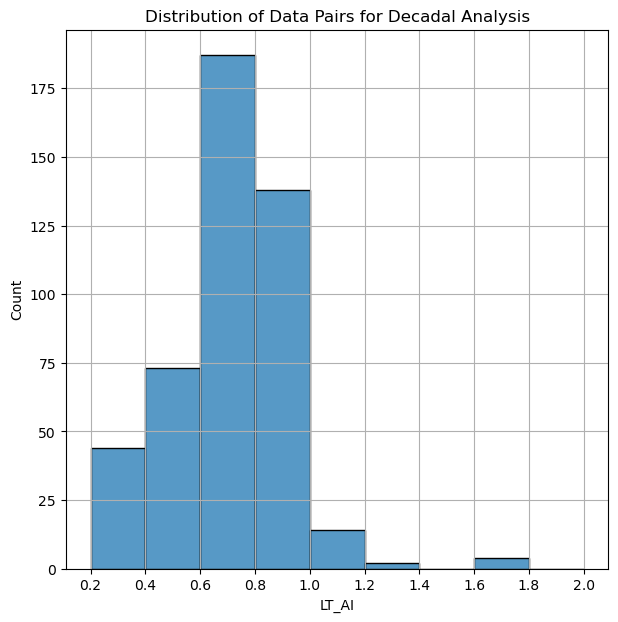

In [313]:
aridity_table1 = combo.set_index('system_index').sort_values('LT_AI')
aridity_table1['AI_group_narrow'] = pd.cut(aridity_table1['LT_AI'], AI_levels, labels=[f'{float(AI_levels[0])}-{float(AI_levels[1])}',
                                                                                     f'{float(AI_levels[1])}-{float(AI_levels[2])}',
                                                                                     f'{float(AI_levels[2])}-{float(AI_levels[3])}',
                                                                                     f'{float(AI_levels[3])}-{float(AI_levels[4])}',
                                                                                     f'{float(AI_levels[4])}-{float(AI_levels[5])}',
                                                                                     f'{float(AI_levels[5])}-{float(AI_levels[6])}',
                                                                                     f'{float(AI_levels[6])}-{float(AI_levels[7])}',
                                                                                     f'{float(AI_levels[7])}-{float(AI_levels[8])}',
                                                                                     f'{float(AI_levels[8])}-{float(AI_levels[9])}',], ordered=True)
grouped1 = aridity_table1.groupby('AI_group_narrow')

dist = []

for group, indices in grouped1.indices.items():
    
    print(f"Group: {group}, indice: {len(indices)}")
    dist.append(len(indices))

colors5 = ['#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034']

#222222
fig = plt.figure(figsize=(7, 7))
sns.histplot(aridity_table1.LT_AI, bins=AI_levels)
plt.xticks(AI_levels)
plt.grid()
plt.title('Distribution of Data Pairs for Decadal Analysis');

In [318]:
def w_function(AI, w):
    EI = 1 + AI - (1 + (AI**w))**(1/w)
    return EI

In [444]:
plt.figure(99)
def many_w_curves(groups):
    ls_EI = []
    ls_AI = []
    for i, (group, indices) in enumerate(groups):
        
        if i <=4:
            AI = np.linspace(AI_levels[i], AI_levels[i+1], 150)
            w = grouped1.mean()['omega'][i]
            EI_curve = w_function(AI, w)
            plt.plot(AI, EI_curve, linewidth=2, c=colors5[i], label=f'mean $\omega$ ={w:.3f}, AI: {group}')
            ls_EI.append(EI_curve)
            ls_AI.append(AI)
         
        else:
            break
    return [ls_EI, ls_AI]

#def fill_between_curves():

<Figure size 640x480 with 0 Axes>

Group: 0.2-0.4, indice: 22
Group: 0.4-0.6, indice: 34
Group: 0.6-0.8, indice: 78
Group: 0.8-1.0, indice: 61
Group: 1.0-1.2, indice: 5
Group: 1.2-1.4, indice: 1
Group: 1.4-1.6, indice: 0
Group: 1.6-1.8, indice: 2
Group: 1.8-2.0, indice: 0


C:\Users\creeb\AppData\Local\Temp\ipykernel_29824\3400530083.py:24: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(aridity_table.LT_AI, bins=AI_levels, palette=colors5)


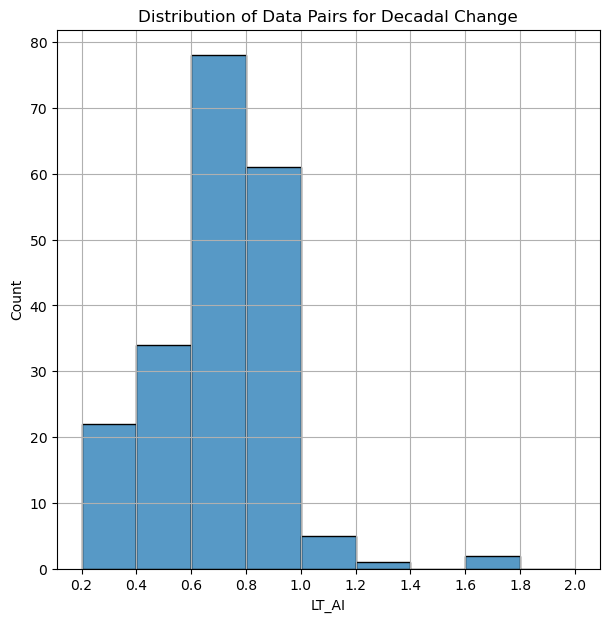

In [445]:
aridity_table = d_combo.set_index('system_index').sort_values('LT_AI')
aridity_table['AI_group_narrow'] = pd.cut(aridity_table['LT_AI'], AI_levels, labels=[f'{float(AI_levels[0])}-{float(AI_levels[1])}',
                                                                                     f'{float(AI_levels[1])}-{float(AI_levels[2])}',
                                                                                     f'{float(AI_levels[2])}-{float(AI_levels[3])}',
                                                                                     f'{float(AI_levels[3])}-{float(AI_levels[4])}',
                                                                                     f'{float(AI_levels[4])}-{float(AI_levels[5])}',
                                                                                     f'{float(AI_levels[5])}-{float(AI_levels[6])}',
                                                                                     f'{float(AI_levels[6])}-{float(AI_levels[7])}',
                                                                                     f'{float(AI_levels[7])}-{float(AI_levels[8])}',
                                                                                     f'{float(AI_levels[8])}-{float(AI_levels[9])}',], ordered=True)
grouped = aridity_table.groupby('AI_group_narrow')

dist = []

for group, indices in grouped.indices.items():
    
    print(f"Group: {group}, indice: {len(indices)}")
    dist.append(len(indices))

colors5 = ['#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034']


fig = plt.figure(figsize=(7, 7))
sns.histplot(aridity_table.LT_AI, bins=AI_levels, palette=colors5)
plt.xticks(AI_levels)
plt.grid()
plt.title('Distribution of Data Pairs for Decadal Change');

In [446]:
combo

,B4,ndbi,country_code,system_index,catchment_name,ndvi,SI,LT_SR,B2,Unnamed: 0,...,is_dur,gndvi,EI,ndmi,B5,AI,nbr,omega,GREENNESS,B1
0,3505.870580,-0.261393,FR,00000000000000000027,La Meuse Stenay,0.646986,0.130338,136.127009,795.529580,0,...,4.209709,0.630203,0.523830,0.261393,2075.404309,0.723527,0.535894,2.195433,1947.346107,500.667264
1,3854.445260,-0.279797,FR,0000000000000000001c,La Vence la Francheville,0.706225,0.222241,185.448285,770.271634,1,...,4.320080,0.669060,0.409847,0.279797,2176.186161,0.538129,0.570896,2.050072,2283.432161,473.134882
2,3689.468405,-0.281666,FR,00000000000000000023,La Bar Cheveuges,0.688455,0.190065,267.844657,771.648832,2,...,4.293069,0.656230,0.580658,0.281666,2084.878494,0.600242,0.571166,4.632337,2146.471886,480.667394
3,3548.118212,-0.273264,FR,00000000000000000026,Le Loison Han-lÃ©s-Juvigny,0.682117,0.181241,259.431829,735.486661,3,...,4.365462,0.655333,0.617702,0.273264,2045.911644,0.638256,0.561081,4.983403,2059.632583,451.629263
4,3645.584904,-0.266628,FR,00000000000000000028,La Meuse Saint-Mihiel,0.679064,0.125189,161.677726,751.406663,4,...,4.304854,0.657088,0.515176,0.266628,2117.114887,0.745344,0.549572,2.088425,2109.174757,461.019370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342,3541.974049,-0.209105,USA,00000000000000000189,6918460,0.691508,0.324501,247.678067,721.111353,110,...,4.960526,0.661745,0.649748,0.209105,2325.578170,0.789386,0.519866,3.037955,2058.221842,423.576431
343,3318.558560,-0.346872,USA,000000000000000000ae,2408540,0.759770,0.246640,327.831899,615.376156,111,...,4.340716,0.691274,0.616032,0.346872,1617.640465,0.713759,0.663835,3.167783,2066.176294,425.274563
345,3074.025147,-0.118995,USA,00000000000000000179,6814000,0.621653,0.439232,311.800764,754.579495,113,...,5.782341,0.603448,0.783979,0.118995,2418.954823,1.011441,0.397014,3.479584,1609.813100,460.490084
347,2610.546573,0.018127,USA,000000000000000001c5,8086290,0.427434,0.201453,459.384967,955.267865,115,...,8.708571,0.465112,0.938728,-0.018127,2716.352334,1.529400,0.217651,4.103516,938.028048,624.630277


<Figure size 640x480 with 0 Axes>

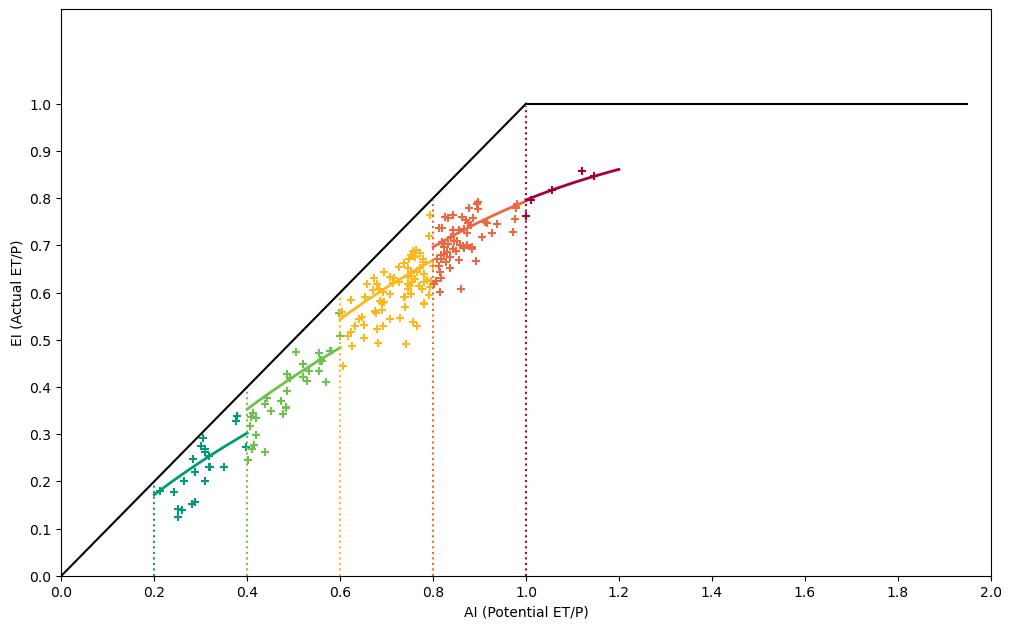

In [595]:
fignum +=1
plt.figure(fignum)

colors5 = ['#009B77', '#6CC24A','#FFB81C', '#EC6842', '#A50034']

budyko_curve_x = np.arange(1, 2, 0.05)
energy_limit_x = np.arange(0, 1.0001, 0.05)
x = np.arange(0, 1.0001, 0.05)
water_limit_y = 1 + budyko_curve_x*0
energy_limit_y = energy_limit_x
y = 1 + x*0

levels = [0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(10,6.18))

plt.ylabel("EI (Actual ET/P)")
plt.xlabel("AI (Potential ET/P)")

plt.xlim(0,2)
plt.ylim(0, 1.2)



plt.yticks([0,0.1,0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks([0,0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]);

ls_EI, ls_AI = many_w_curves(grouped1)

combo = combo.drop_duplicates(subset='system_index', keep='first')
cap_segments_energy_limit =  np.arange(0.2, 1.2, 0.2)

n_catchments = 0

for i in range(len(colors5)):
    mask = (combo['LT_AI'] >= AI_levels[i]) & (combo['LT_AI'] <= AI_levels[i+1])
    
    masked = combo[mask]
    n = len(list(grouped1.groups.values())[i])
    n_catchments += n
    scatter1 = ax.scatter(masked.LT_AI, masked.LT_EI, c = colors5[i], label=f'Catchment AI {list(grouped1.groups.keys())[i]}, n={n}', marker='+')
    v1 = plt.axvline(AI_levels[i], ymin=0, ymax=((cap_segments_energy_limit[i]/1)*0.83), c=colors5[i], linestyle=':')
    
plt.plot(energy_limit_x, energy_limit_y, c='k')
plt.plot(budyko_curve_x, water_limit_y,c='k')
    
#cbar.set_ticks(AI_levels)
#cbar.set_ticklabels(colors9)

#plt.suptitle(f'All Catchments, All Time, n={n_catchments}')
#plt.title('Dataset Grouped by Aridity Index')

#plt.legend();



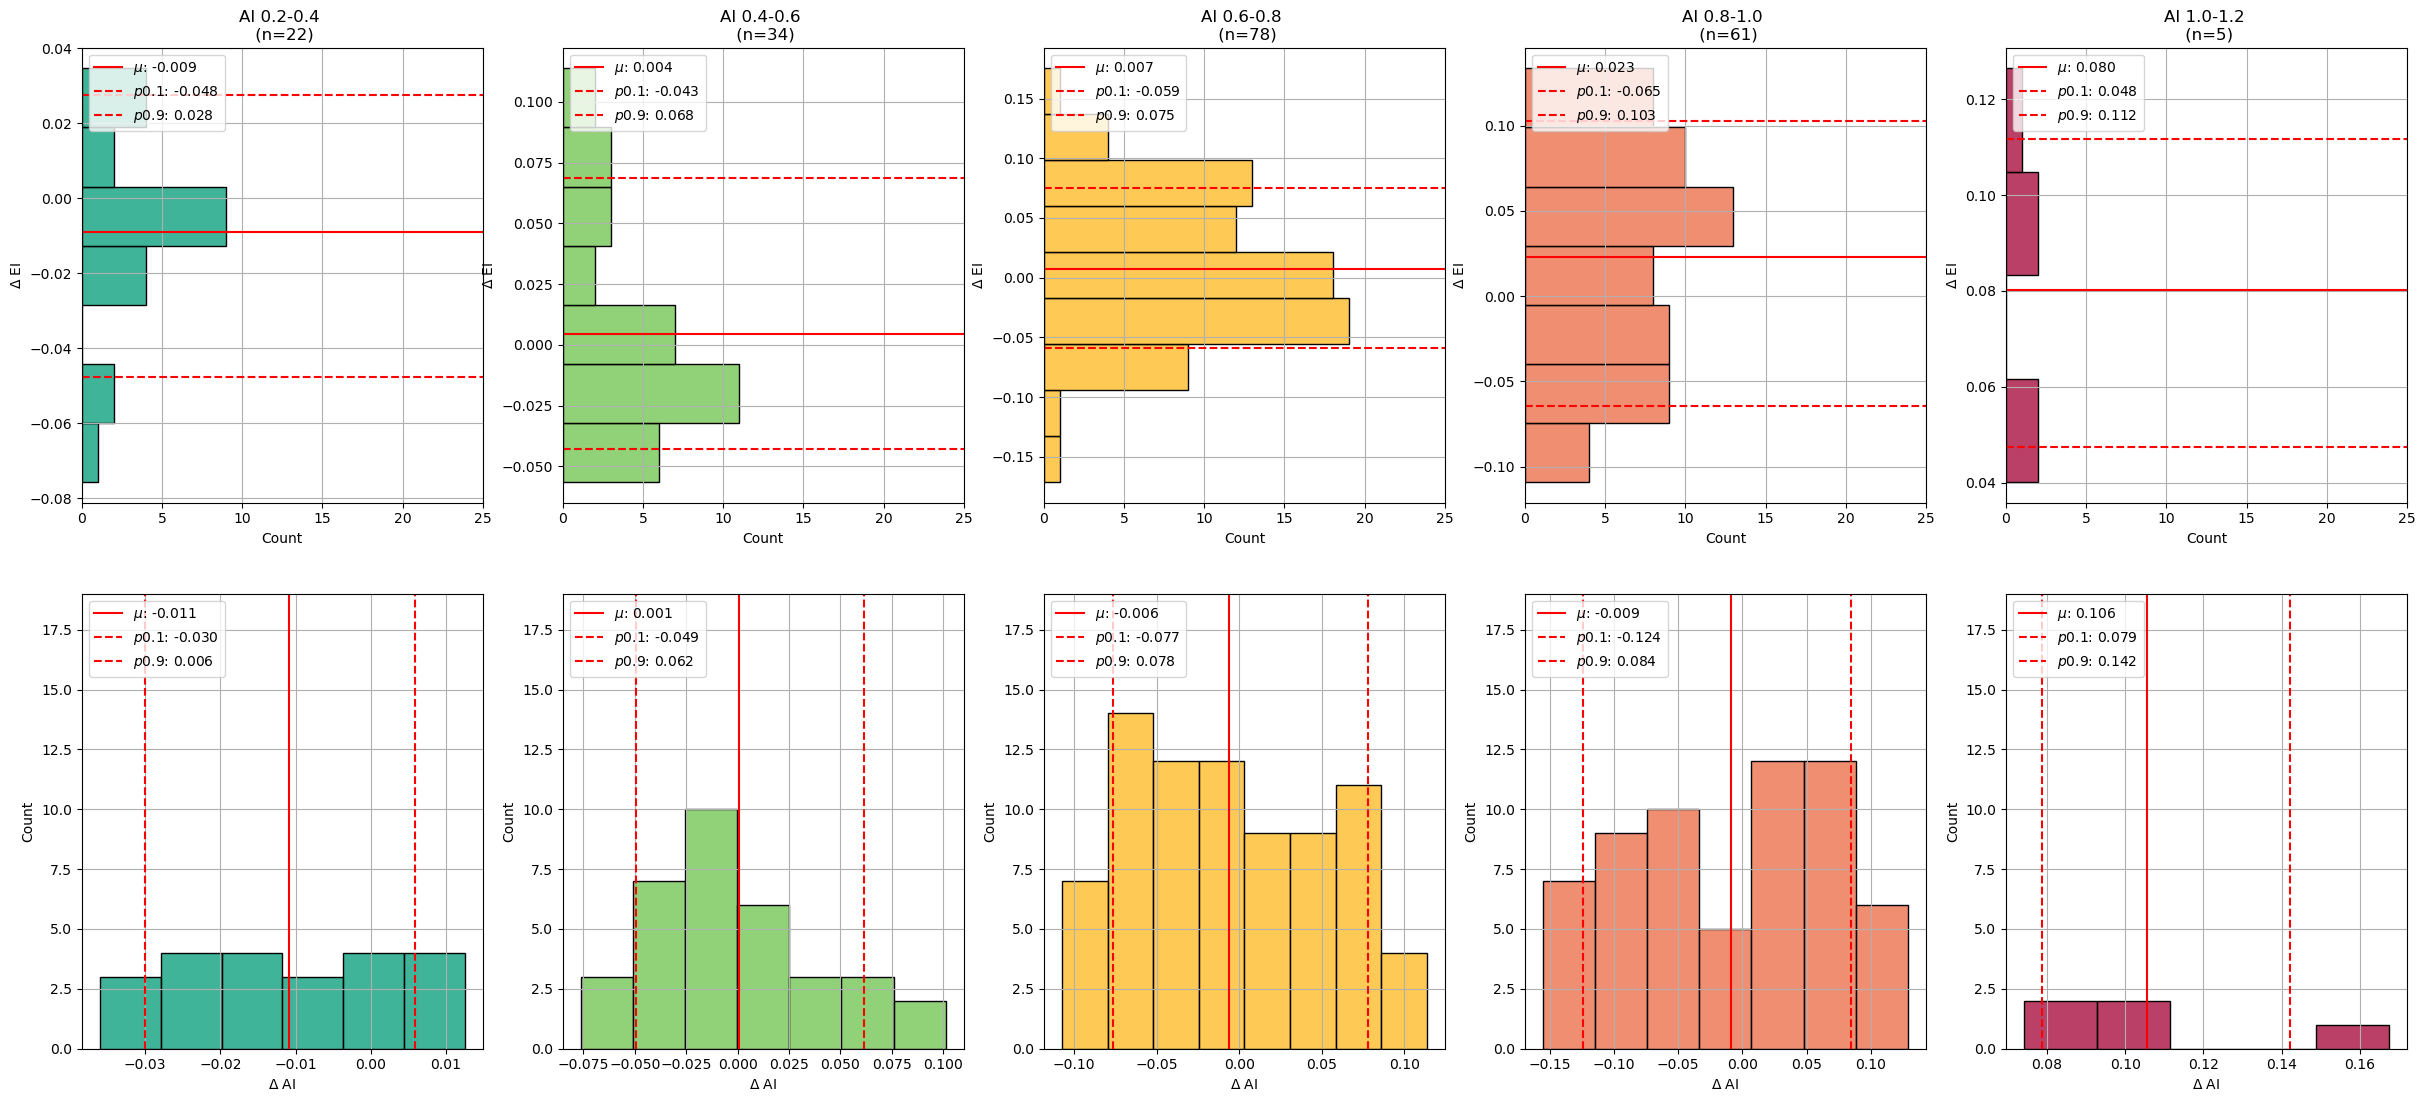

In [593]:
fig, ax = plt.subplots(2, 5, figsize=(30, 13))

n = []

index = np.arange(0, 6)

gp=0


for i, (group, data) in enumerate(grouped):
    #if group is not None:
    #    print(data)
    #    break
    
    lim = 0.9#np.max(abs(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']))
    
    
    if len(data) >0 and lim <1 and i <5:  
        n=0
        
        x1 = data.d_EI
        #x1.plot.hist(ax=ax[n,i], alpha=0.5, label=group, color='lime')#, sharey=True)
        sns.histplot(y=x1, ax=ax[0,i], color = colors5[i], orientation='horizontal')
        #x = aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']
        
        mu = np.mean(x1)
        
        p10 = np.percentile(x1, 10)
        
        p90 = np.percentile(x1, 90)
        
        #x.plot.hist(alpha=0.5)#, label=f'{group}, n= {len(indice)}', edgecolor='black', linewidth=1.2, ax=ax1)
        
        ax[0,i].set_ylabel(f'$\Delta$ EI')
        ax[0,i].set_title(f'AI {group} \n (n={len(data)})')
        #ax.axvline(np.mean(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'LT_EI']))
        #plt.grid(visible=True, alpha=0.5)
        ax[0,i].axhline(mu, c='r', label=f'$\mu$: {mu:.3f}')
        ax[0,i].axhline(p10, c='r', ls='--', label=f'$p0.1$: {p10:.3f}')
        ax[0,i].axhline(p90, c='r', ls='--', label=f'$p0.9$: {p90:.3f}')
        ax[0,i].set_ylim(0.17, 0.17)
        ax[0,i].set_xlim(17.5)
        ax[0,i].grid()
        ax[0,i].legend(loc='upper left')
        
    
    #lim = np.max(abs(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']))
    
    if len(data) >0 and lim <1 and i <5:  
        n=2
        #ax[1,i].add_subplot(sharey=True)
        x1 = data.d_AI
        #x1.plot.hist(ax=ax[n,i], alpha=0.5, label=group)#, sharey=True)
        sns.histplot(x=x1, ax=ax[1, i], color = colors5[i])
        #x = aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'd_EI']
        
        mu = np.mean(x1)
        
        p10 = np.percentile(x1, 10)
        
        p90 = np.percentile(x1, 90)
        
        ax[1,i].set_xlabel(f'$\Delta$ AI')
        #ax[n,i].set_title(f'EI {group}')
        #ax.axvline(np.mean(aridity_table.iloc[int(indice[0]):int(indice[-1])].loc[:, 'LT_EI']))
        #plt.grid(visible=True, alpha=0.5)
        #ax[1,i].set_title(f'AI {group} \n (n={len(data)})')
        ax[1,i].axvline(mu, c='r', label=f'$\mu$: {mu:.3f}')
        ax[1,i].axvline(p10, c='r', ls='--', label=f'$p0.1$: {p10:.3f}')
        ax[1,i].axvline(p90, c='r', ls='--', label=f'$p0.9$: {p90:.3f}')
        #ax[1,i].set_xlim(-lim*3, lim*3)
        ax[1,i].set_ylim(0, 19)
        ax[1,i].grid()
        ax[1,i].legend(loc='upper left')
    
    
    
    gp +=1
        
  

In [463]:
def mean_line_angle(x, y):
    return np.arctan2(np.mean(np.sin(np.arctan2(y, x))), np.mean(np.cos(np.arctan2(y, x))))
def list_mean_angles(x_list, y_list):
    
    mean_angle_list = []
    
    for i in range(len((x_list))):
        x = x_list[i]
        y = y_list[i]
        mean_angle = mean_line_angle(x, y)
        mean_angle_list.append(mean_angle)
    
    return mean_angle_list

mean_angle_list = list_mean_angles(ls_AI, ls_EI)

for i in mean_angle_list:
    
    print("Mean line angle: {:.2f} radians".format(i))

Mean line angle: 0.68 radians
Mean line angle: 0.70 radians
Mean line angle: 0.72 radians
Mean line angle: 0.69 radians
Mean line angle: 0.65 radians


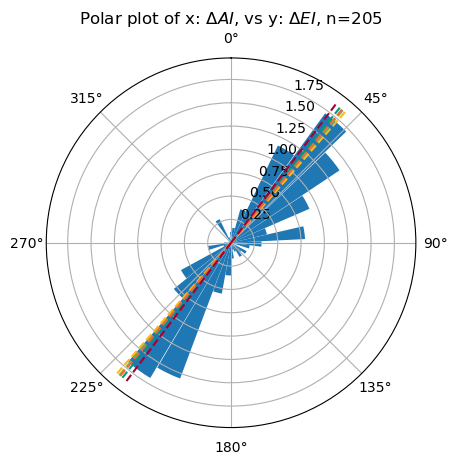

In [597]:
df = d_combo

# Get the angle and magnitude of each data point
angles = np.arctan2(df['d_EI'], df['d_AI'])
magnitudes = np.sqrt(df['d_AI']**2 + df['d_EI']**2)

# Create bins for the angles
bins = np.linspace(-np.pi, np.pi, num=36)

# Create a histogram of the angles
hist, _ = np.histogram(angles, bins=bins, weights=magnitudes)

# Plot the rose diagram
ax = plt.subplot(projection='polar')
ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0)

for i, mean_angle in enumerate(mean_angle_list):#

   ax.plot([0, mean_angle], [0, np.max(hist)*1.1], color=colors5[i], linestyle='dashed')
   ax.plot([0, mean_angle+np.pi], [0, np.max(hist)*1.1], color=colors5[i], linestyle='dashed')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title(f"Polar plot of x: $\Delta AI$, vs y: $\Delta EI$, n={len(d_combo)}")
#plt.suptitle('Change in Aridity vs Evaporative indices ')
plt.show()

## Plotting polar distributions of movement within the budyko framework

magnitude = v = √((x2 – x1)^2 + (y2 – y1)^2)

direction and magnitude of movement within the framework

index [1 2 3 4 5]


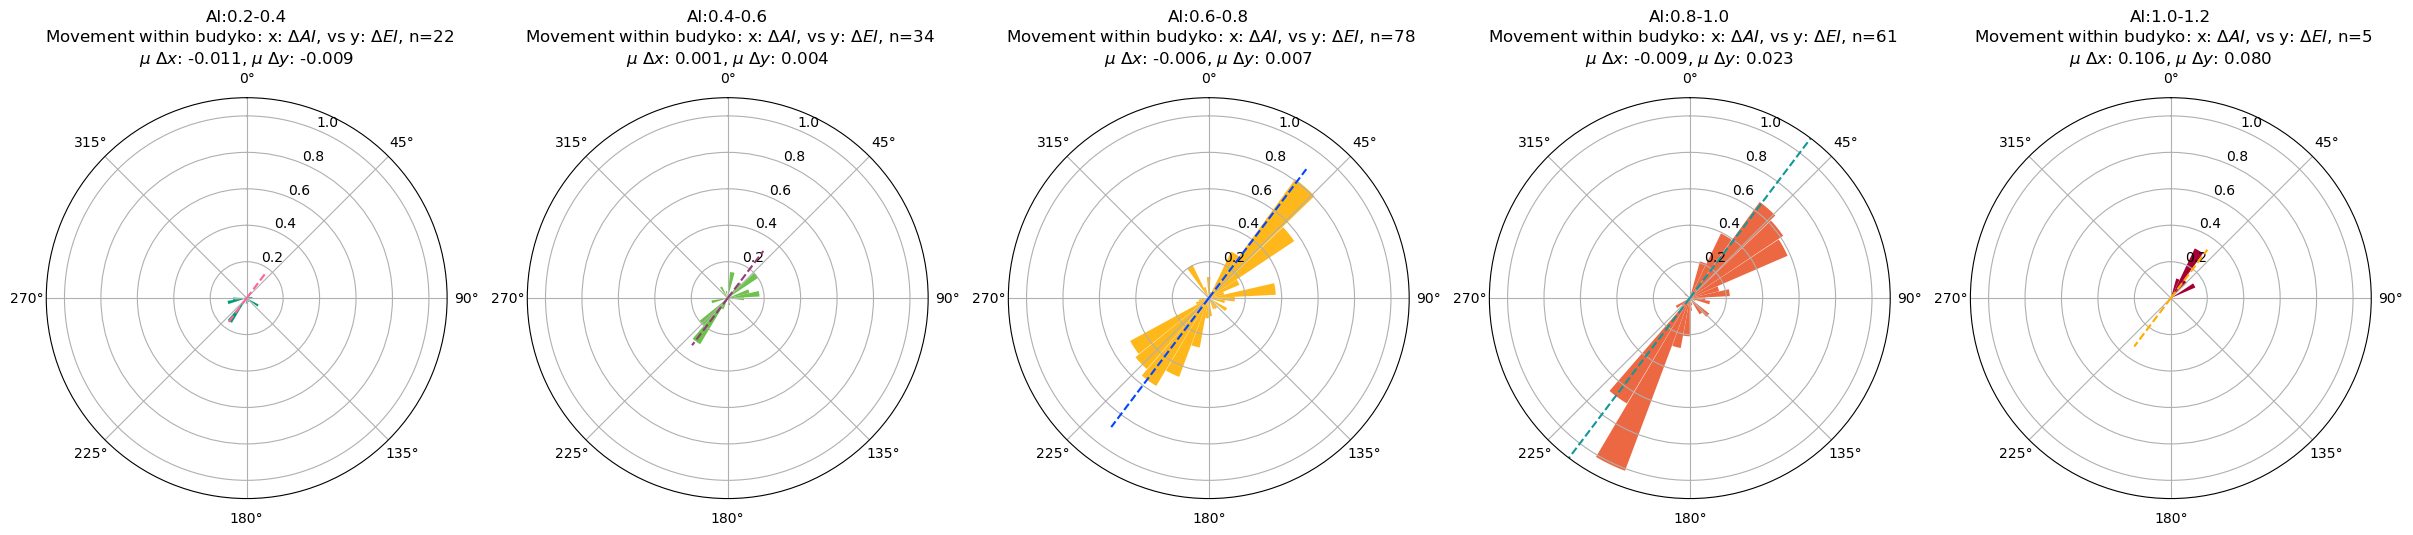

In [468]:
fig, ax = plt.subplots(1, 5, figsize=(30, 7.5))
n=0
index = np.arange(1, 6)
print('index',index)

colors5_inv = ['#FF6499', '#933C75', '#0047FF', '#139799', '#FFAB00']


for i, (group, df) in enumerate(grouped):
    if n <5:
    
        y= df['d_EI']
        x=df['d_AI']

        mu_x = np.mean(x)
        mu_y = np.mean(y)

        # Get the angle and magnitude of each data point
        angles = np.arctan2(y,x)
        magnitudes = np.sqrt(x**2 + y**2)

        # Create bins for the angles
        bins = np.linspace(-np.pi, np.pi, num=36)

        # Create a histogram of the angles
        hist, _ = np.histogram(angles, bins=bins, weights=magnitudes)
        
        # Plot the rose diagram
        ax = plt.subplot(1,5,index[n], projection='polar')
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])
        ax.set_ylim(0, 1.1)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        
        mean_angle_ex = mean_angle_list[i]
        ax.plot([0, mean_angle], [0, np.max(hist)*1.1], color=colors5_inv[i], linestyle='dashed')
        ax.plot([0, mean_angle+np.pi], [0, np.max(hist)*1.1], color=colors5_inv[i], linestyle='dashed')
        
        #ax.suptitle(f'AI group: {group}')
        ax.set_title(f"AI:{group}\n Movement within budyko: x: $\Delta AI$, vs y: $\Delta EI$, n={len(df)}\n$\mu$ $\Delta x$: {mu_x:.3f}, $\mu$ $\Delta y$: {mu_y:.3f}")
        n+=1
    else:
        break

What can we say about SR vs Tendencies in EI per AI

index [1 2 3 4 5]


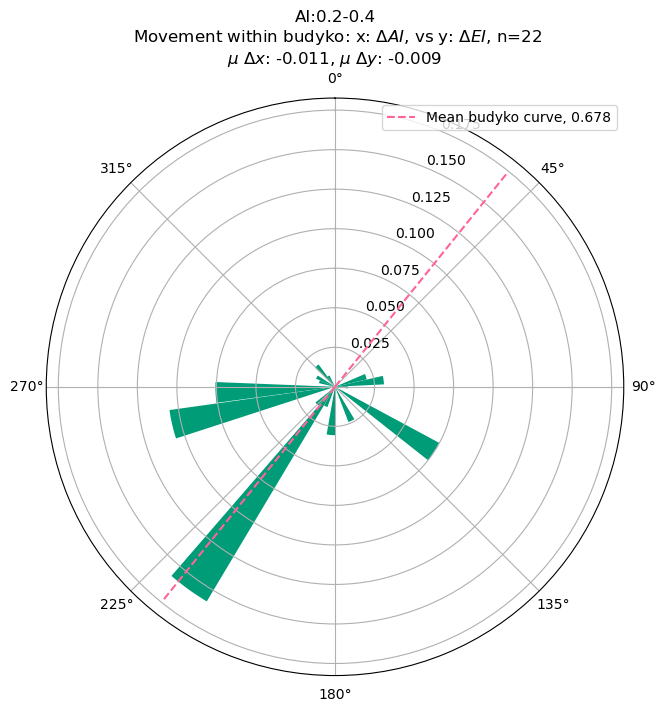

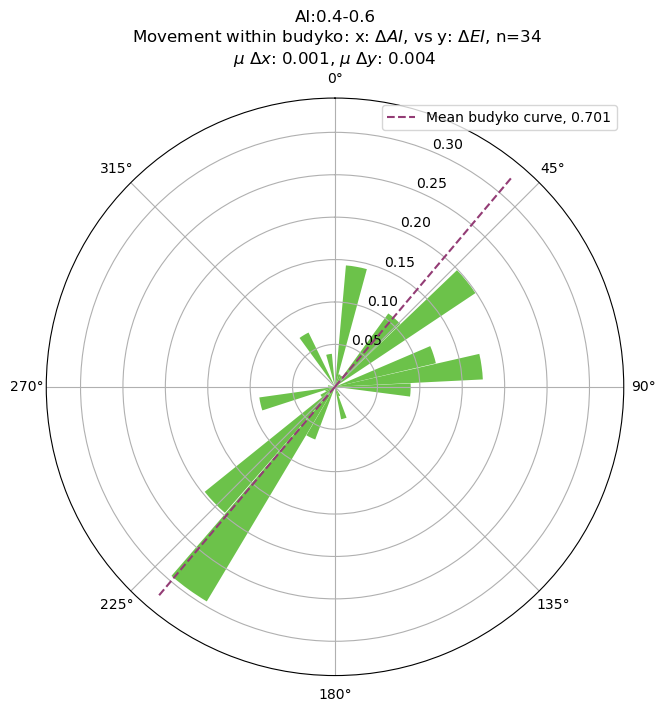

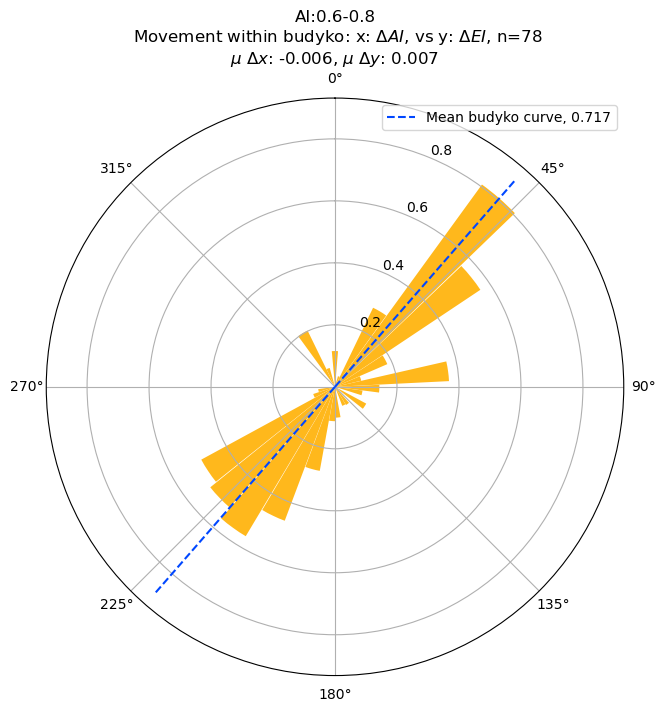

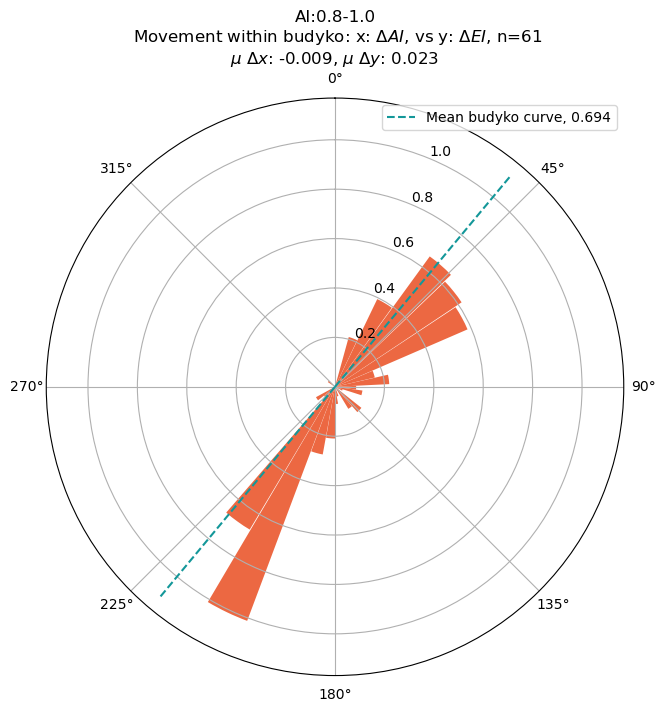

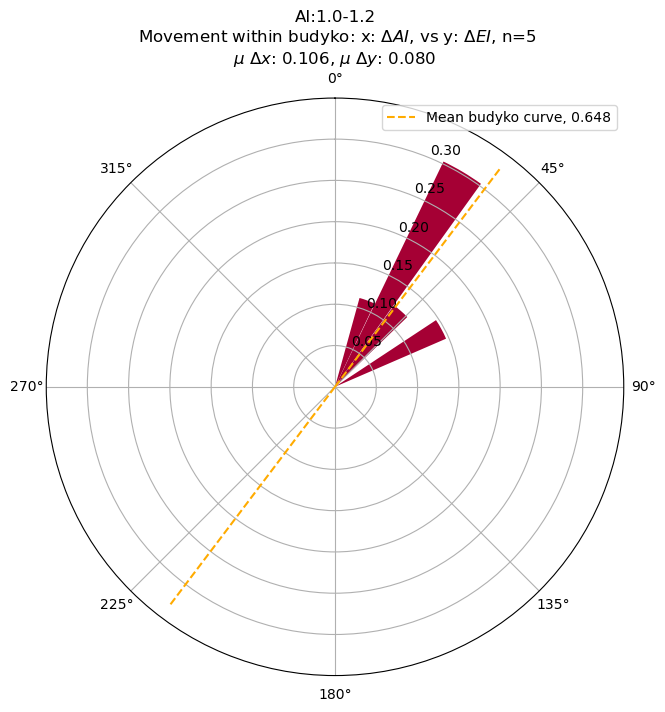

In [600]:
n=0
index = np.arange(1, 6)
print('index',index)

colors5_inv = ['#FF6499', '#933C75', '#0047FF', '#139799', '#FFAB00']


for i, (group, df) in enumerate(grouped):
    if n <5:
        fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))

        y= df['d_EI']
        x=df['d_AI']

        mu_x = np.mean(x)
        mu_y = np.mean(y)

        # Get the angle and magnitude of each data point
        angles = np.arctan2(y,x)
        magnitudes = np.sqrt(x**2 + y**2)

        # Create bins for the angles
        bins = np.linspace(-np.pi, np.pi, num=36)

        # Create a histogram of the angles
        hist, _ = np.histogram(angles, bins=bins, weights=magnitudes)
        
        # Plot the rose diagram
        ax = plt.subplot(1,1,1, projection='polar')
        ax.bar(bins[:-1], hist, width=2*np.pi/36, align='edge', bottom=0, color=colors5[n])
        #ax.set_ylim(0, 1.1)
        ax.set_theta_zero_location("N")
        ax.set_theta_direction(-1)
        
        mean_angle = mean_angle_list[i]
        ax.plot([0, mean_angle], [0, np.max(hist)*1.1], color=colors5_inv[i], linestyle='dashed', label=f"Mean budyko curve, {mean_angle:.3f}")
        ax.plot([0, mean_angle+np.pi], [0, np.max(hist)*1.1], color=colors5_inv[i], linestyle='dashed')
        
        ax.set_title(f"AI:{group}\n Movement within budyko: x: $\Delta AI$, vs y: $\Delta EI$, n={len(df)}\n$\mu$ $\Delta x$: {mu_x:.3f}, $\mu$ $\Delta y$: {mu_y:.3f}")
        ax.legend()
        n+=1
    else:
        break

In [516]:
def plot_descending_P(SR_index:[], df_all, sorted_p, prs_r, exclude, delta=False, plot=False, savefig=False, color_by=str, levels=[], folder_stem=str, group=str):
    '''
    The function loops through the list of Surface Reflectance indices passed. The plotting returns scatters in descending
    order from   to:  1 > p-value > 0.01 
    '''
    ls = []
    
    for i in SR_index:
        
        if delta==True:
            i = f'd_{i}'

        high_to_low_id = sorted_p.loc[:, f'{i}_vs']
        high_to_low_p = sorted_p.loc[:, f'{i}_p']
        
        for j in zip(high_to_low_id, high_to_low_p):
            if j[1] < 0.1 and j[0] not in exclude:
                
                
                r = prs_r.loc[i, j[0]]
                ls.append((i, j[0], j[1], r))
                
                
                if plot == True:
                    plt.figure(figsize=(10, 6.18))
                    
                    
                    
                    x = df_all.loc[:, i] 

                    y = df_all.loc[:, j[0]]


                    plt.suptitle(f'$p$: {j[1]:.3e}, $r$= {r:.3e}, $n$ = {len(x)}')
        
                    plt.xlabel(i)

                    plt.ylabel(j[0])
                
                
                if delta==True and plot == True:
                    
                    plt.title(f'{group}: $\Delta$ {i[2:]}  vs $\Delta$ {j[0][2:]}')
                    
                    plt.scatter(x, y, c=df_all.loc[:,  color_by], alpha=0.6)
    
                    plt.colorbar(ticks=levels, label=color_by)
                    
                    plt.xlabel(f'$\Delta${i[2:]}')

                    plt.ylabel(f'$\Delta${j[0][2:]}')
        
                    if savefig == True:
                
                        plt.savefig(f'{folder_stem}/{group}/{group}_{i}_{j[0]}_{color_by}.png')

                elif delta==False and plot == True:    
                    

                    plt.title(f'{group}: {i} vs  {j[0]}')
                    
                    plt.scatter(x, y, c=df_all.loc[:,  color_by], alpha=0.6)
                    
                    plt.colorbar(ticks=levels, label=color_by)
                    
                    if savefig == True:
                        plt.savefig(f'{folder_stem}/{group}/{group}_{i}_{j[0]}_{color_by}.png')
                
                ##if j[1] <= 0.1:
                    #break
                
            else:
                None
        
    return ls

In [518]:
#ranking = plot_descending_P(SR_indices, combo, sort_p, prs_r, SR_exclude, delta=False, plot=True, savefig=True, color_by='LT_AI', levels = AI_levels)
ranking_list = []

folder_stem='outputs/SR_delta_correlations_grouped'

for i, (group, data) in enumerate(grouped):
    #display(data.keys())
    #print(group)
    SR_exclude=['d_B1','d_B2','d_B3','d_B4','d_B5','d_B7',]
    levels = np.linspace(data.LT_SR.min(), data.LT_SR.max(), 10)
    if data.shape[0] > 1:
        prs_r = data.corr()
        p = data.corr(method=pearsonr_pval)
        sort_p = sorted_p(p)
        ranking = plot_descending_P(SR_indices, data, sort_p, prs_r, SR_exclude, delta=True, plot=False, savefig=True, color_by='LT_SR', levels = levels, folder_stem=folder_stem, group=group)
        ranking_list.append((group, ranking))
    else:
        break

C:\Users\creeb\anaconda3\envs\BPD4a\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
C:\Users\creeb\anaconda3\envs\BPD4a\lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [596]:
for i, (group, data) in enumerate(ranking_list):
    headers= ['d_SR_IND', 'd_WB_IND', 'p', 'r']
    df = pd.DataFrame(data, columns=headers)
    AI_mask = (df['d_WB_IND'] == 'd_AI')
    EI_mask = (df['d_WB_IND'] == 'd_EI')
    EI_rank = df[EI_mask]
    AI_rank = df[AI_mask]
    
    display(EI_rank)
    display(AI_rank)
    

    if AI_rank.shape[0] > 0 and EI_rank.shape[0] > 0:
        
        EI_best = (EI_rank.loc[EI_rank.p.idxmin(), 'd_SR_IND'], EI_rank.loc[EI_rank.p.idxmin(), 'd_WB_IND'])
        AI_best = (AI_rank.loc[AI_rank.p.idxmin(), 'd_SR_IND'], AI_rank.loc[AI_rank.p.idxmin(), 'd_WB_IND'])
                
        print(f' for {group} EI, {EI_best[0]} is most highly correlated with {EI_best[1]}\n')
        print(f' for {group} AI, {AI_best[0]} is most highly correlated with {AI_best[1]}\n')
    
    elif AI_rank.shape[0] > 0 & EI_rank.shape[0] == 0:
        
        AI_best = (AI_rank.loc[AI_rank.p.idxmin(), 'd_SR_IND'], AI_rank.loc[AI_rank.p.idxmin(), 'd_WB_IND'])
                
        print(f' for {group} no EI correlation p < 10 percent\n')
        print(f' for {group} AI, {AI_best[0]} is most highly correlated with {AI_best[1]}\n')
    
    elif EI_rank.shape[0] > 0 & AI_rank.shape[0] == 0:

        EI_best = (EI_rank.loc[EI_rank.p.idxmin(), 'd_SR_IND'], EI_rank.loc[EI_rank.p.idxmin(), 'd_WB_IND'])

        print(f' for {group} no AI correlation exists p < 10 percent\n')
        print(f' for {group} EI, {EI_best[0]} is most highly correlated with {EI_best[1]}\n')
    
    elif EI_rank.shape[0] == 0 and AI_rank.shape[0] == 0:
        
        print(f'{group} no correlation exists in this group for either AI or EI')



,d_SR_IND,d_WB_IND,p,r
12,d_evi,d_EI,0.012049,0.525339
55,d_GREENNESS,d_EI,0.095666,-0.364181


,d_SR_IND,d_WB_IND,p,r


 for 0.2-0.4 no AI correlation exists p < 10 percent

 for 0.2-0.4 EI, d_evi is most highly correlated with d_EI



,d_SR_IND,d_WB_IND,p,r
1,d_ndvi,d_EI,0.088500,-0.296604
28,d_gndvi,d_EI,0.081439,-0.303081


,d_SR_IND,d_WB_IND,p,r
0,d_ndvi,d_AI,0.092531,-0.293082
29,d_gndvi,d_AI,0.063763,-0.321457


 for 0.4-0.6 EI, d_gndvi is most highly correlated with d_EI

 for 0.4-0.6 AI, d_gndvi is most highly correlated with d_AI



,d_SR_IND,d_WB_IND,p,r


,d_SR_IND,d_WB_IND,p,r
48,d_BRIGHTNESS,d_AI,0.003969,0.322602
64,d_WETNESS,d_AI,0.005298,-0.312799


 for 0.6-0.8 no EI correlation p < 10 percent

 for 0.6-0.8 AI, d_BRIGHTNESS is most highly correlated with d_AI



,d_SR_IND,d_WB_IND,p,r
5,d_ndvi,d_EI,0.000520,0.431285
26,d_nbr,d_EI,0.002149,0.385591
41,d_ndmi,d_EI,0.001807,0.391521
53,d_gndvi,d_EI,0.000289,0.448541
69,d_ndbi,d_EI,0.001807,-0.391521
78,d_BRIGHTNESS,d_EI,0.090867,-0.218386
97,d_GREENNESS,d_EI,0.000031,0.506825
105,d_WETNESS,d_EI,0.041764,0.261521


,d_SR_IND,d_WB_IND,p,r
4,d_ndvi,d_AI,0.000685,0.422916
27,d_nbr,d_AI,0.001455,0.398798
42,d_ndmi,d_AI,0.001153,0.406430
52,d_gndvi,d_AI,0.000348,0.443190
70,d_ndbi,d_AI,0.001153,-0.406430
77,d_BRIGHTNESS,d_AI,0.092617,-0.217241
95,d_GREENNESS,d_AI,0.000068,0.487408
107,d_WETNESS,d_AI,0.030737,0.276914


 for 0.8-1.0 EI, d_GREENNESS is most highly correlated with d_EI

 for 0.8-1.0 AI, d_GREENNESS is most highly correlated with d_AI



,d_SR_IND,d_WB_IND,p,r
2,d_ndvi,d_EI,0.007062,-0.967306
12,d_evi,d_EI,0.010059,0.958572
23,d_nbr,d_EI,0.002174,-0.985121
32,d_ndmi,d_EI,0.004020,-0.977566
42,d_gndvi,d_EI,0.003001,-0.981544
52,d_ndbi,d_EI,0.004020,0.977566
67,d_GREENNESS,d_EI,0.006276,-0.969785
78,d_WETNESS,d_EI,0.003811,-0.978353


,d_SR_IND,d_WB_IND,p,r


 for 1.0-1.2 no AI correlation exists p < 10 percent

 for 1.0-1.2 EI, d_nbr is most highly correlated with d_EI



# Corine Land Classes




In [ ]:
meuse_sysind = meuse.system_index.to_list()
classes = pd.read_excel('meuse/CORINE/land_cover_classes.xlsx')

periods = [1990, 2000, 2006, 2012, 2018]

len(meuse_sysind)*len(periods)



In [ ]:
df = pd.read_excel('meuse/CORINE/lc_0000000000000000001c_1990.xlsx')
df

In [ ]:
def meuse_class_table(classes, periods, sys_ind):
    '''
    For each land class table append the value to a combined table 
    '''
    combined_classes = pd.DataFrame(columns=classes.Value.astype(str))#, classes.Description, classes.loc[:,'Color Value']])#.insert(1, 'system_index', meuse_sysind[:])
    combined_classes.insert(0, 'period', np.nan, True)
    combined_classes.insert(0, 'system_index', 'a', True)
    combined_classes.set_index('system_index')
   
    #combined_classes.rename(columns={'Value':'system_index'})
    combined_classes.index.name = None
    

    row = 1

    for i, year in enumerate(periods):

        for j,  sys in enumerate(sys_ind[:]):
            
            filepath = f'meuse/CORINE/lc_{sys}_{year}.xlsx'
            

            df = pd.read_excel(filepath, converters={'system_index':str}, index_col='system_index')
            
            
            
            combined_classes.loc[row, 'period'] = int(year)
            combined_classes.loc[row, 'system_index'] = str(sys)
            combined_classes.set_index('system_index')
            
            df_set = list(df.keys()[:])
            cc_set = set(combined_classes.keys()[-44:])
            intersection = list(cc_set.intersection(df_set))
            
            l = df.index.values[0]
            
            
            
            for k in df_set:
                #print(df.loc[l, k])
                combined_classes.loc[row, k] = float(df.loc[l, k])
            
            row +=1
    combined_classes['summed'] = combined_classes.iloc[2:-1].sum(axis=1)
            
    return combined_classes
            


In [ ]:
meuse_table = meuse_class_table(classes, periods, meuse_sysind)
meuse_table.summed = meuse_table.iloc[:, 2:-1].sum(axis=1)


In [ ]:
grouped = meuse_table.groupby('period')

dfs = []

for i, (group, data) in enumerate(grouped):
    
    summed = data.sum()
    to_pct = np.cumsum(summed[2:-1])[-1]
    
    dic = {'year' : group,
           'artificial': np.cumsum(summed[2:13])[-1],#/to_pct, 
           'agricultural' : np.cumsum(summed[14:24])[-1],#/to_pct,
           'for_s_natural' : np.cumsum(summed[24:36])[-1],#/to_pct,
           'wetland' : np.cumsum(summed[36:41])[-1],#/to_pct, 
           'waterbody' : np.cumsum(summed[41:-1])[-1],}#/to_pct}
    
    dfs.append(pd.DataFrame(dic, index=[0]))



In [ ]:
table_90 = meuse_table.iloc[:grouped[1990][-1]]
table_00 = meuse_table.iloc[grouped[2000][0]:grouped[2000][-1]]
table_06 = meuse_table.iloc[grouped[2006][0]:grouped[2006][-1]]
table_12 = meuse_table.iloc[grouped[2012][0]:grouped[2012][-1]]
table_18 = meuse_table.iloc[grouped[2018][0]:grouped[2018][-1]]

display(table_90)

artificial = [111, 142]
agricultural = [211, 244]
for_s_natural = [311, 335]
wetland = [411, 423]
waterbodies = [511, 523]

table_list = [table_90,table_00, table_06, table_12, table_18]

cols = ['year','artificial','agricultural','for_s_natural','wetland','waterbody']

full = pd.DataFrame(columns=cols)

fig, ax = plt.subplots(1, 5, figsize=(30, 5))
yr =[]
art = []
ag = []
fors = []
wet = []
wat = []

for i, table in enumerate(table_list):
    
    year = list(grouped)[i]
    display(summed_table)
    summed_table = table.sum()
    to_pct = summed_table.summed
    #display(summed_table[41:])
    
    
    dic = {'year' : year,
           'artificial': summed_table[2:13].sum()/to_pct, 
           'agricultural' : summed_table[14:24].sum()/to_pct,
           'for_s_natural' : summed_table[24:36].sum()/to_pct,
           'wetland' : summed_table[36:41].sum()/to_pct, 
           'waterbody' : summed_table[41:-1].sum()/to_pct}
    
    cat = pd.DataFrame(dic, index=[0])
    
    yr.append(cat.year)
    art.append(cat.artificial)
    
    
    cat.loc[0, 'artificial':'waterbody'].plot(kind='bar', ax=ax[i], title=f'CORINE mean percentage $/km^2$, {year}')
    
    
    

full

In [ ]:
meuse_table.iloc[0, :]